In [2]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

import matplotlib 
if not is_notebook():
    matplotlib.use('Agg')

In [3]:
import os
import math
import json
import random as rnd
from typing import Optional, Callable
from tqdm import tqdm
from collections import defaultdict
from functools import partial
from datetime import datetime
import itertools
from dataclasses import dataclass
from pathlib import Path
from enum import Enum

from omegaconf import OmegaConf
import submitit
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import matplotlib.pyplot as plt
import pandas as  pd
import torchvision.utils as vision_utils
from PIL import Image
import torchvision
from torchvision import transforms
from matplotlib.ticker import NullFormatter

from losses.divdis import DivDisLoss 
from losses.divdis import DivDisLoss
from losses.ace import ACELoss
from losses.dbat import DBatLoss
from losses.loss_types import LossType

from models.backbone import MultiHeadBackbone
from models.multi_model import MultiNetModel
from models.lenet import LeNet
from utils.utils import conf_to_args
from utils.exp_utils import get_cifar_mnist_exp_dir


# Experiment Utils

In [4]:
@dataclass
class Experiment:
    seed: int
    loss_type: LossType
    model: str
    mix_rate: float
    mix_rate_lower_bound: float
    epochs: int
    lr: float = 1e-3
    aux_weight: float = 1.0

def post_init(exp: Experiment):
    if exp.loss_type == LossType.DIVDIS:
        exp.aux_weight = 10.0



In [4]:
def get_executor(out_dir: Path):
    executor = submitit.AutoExecutor(folder=out_dir)
    executor.update_parameters(
        timeout_min=60 * 48,
        mem_gb=16,
        gres="gpu:1",
        cpus_per_task=4,
        nodes=1,
        slurm_qos="high",
        slurm_array_parallelism=8
    )
    return executor
def get_executor_local(out_dir: Path):
    executor = submitit.LocalExecutor(folder=out_dir)
    executor.update_parameters(
        timeout_min=60 * 48,
    )
    return executor

script_name = "cifar_mnist.py"
def run_experiments(executor, experiments: list[Experiment], script_name: str):

    with executor.batch():
        jobs = []
        for exp in experiments:
            function = submitit.helpers.CommandFunction(
                ["python", script_name] + conf_to_args(exp.__dict__)
            )
            jobs.append(executor.submit(function))
    return jobs

# Run Experiments

In [5]:
seeds = [0, 1, 2]
losses = [LossType.PROB, LossType.DIVDIS, LossType.EXP]
models = ["Resnet50"]
# mix rates and lower bounds (same mix rate and lower bound, fixed lower bound and varying mix rate)
mix_rates = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
mix_rate_lower_bounds = [0.1] # [0.1, 0.5, 1.0]
same_mix_rate_and_lower_bounds = [
    (mix_rate, mix_rate) for mix_rate in mix_rates
]
fixed_lower_bounds_and_mix_rates = list(itertools.product(
    mix_rates, mix_rate_lower_bounds
))
mix_rates_and_lower_bounds = list(set(same_mix_rate_and_lower_bounds + fixed_lower_bounds_and_mix_rates))

mix_rate_to_epoch: dict[float, int] = {
    0.1: 100,
    0.25: 100,
    0.5: 100,
    0.75: 100,
    0.9: 100,
    1.0: 100
}
# mix_rate_to_epoch = defaultdict(lambda: 20)
experiments: list[Experiment] = []

for seed in seeds:
    for loss in losses:
        for model in models:
            for mix_rate, mix_rate_lower_bound in mix_rates_and_lower_bounds:
                epochs = mix_rate_to_epoch[mix_rate]
                exp = Experiment(
                    seed=seed,
                    loss_type=loss,
                    model=model,
                    mix_rate=mix_rate,
                    mix_rate_lower_bound=mix_rate_lower_bound,
                    epochs=epochs,
                )
                post_init(exp)
                experiments.append(exp)
print(len(experiments))

99


In [6]:
out_dir = Path("output_logs/cifar_mnist_sweep")
out_dir.mkdir(exist_ok=True, parents=True)

executor = get_executor(out_dir)
jobs = run_experiments(executor, experiments, script_name)


/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [7]:
print(jobs[0].stderr())
print(jobs[0].stdout())



submitit INFO (2024-10-24 16:41:11,271) - Starting with JobEnvironment(job_id=493638_0, hostname=vae.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-10-24 16:41:11,271) - Loading pickle: /nas/ucb/oliveradk/diverse-gen/output_logs/cifar_mnist_sweep/493638_0_submitted.pkl
The following command is sent: "python cifar_mnist.py seed=0 loss_type=PROB model=Resnet50 mix_rate=0.5 mix_rate_lower_bound=0.5 epochs=100"



# Process Results

In [6]:
OUT_DIR = "output"
def get_cifar_mnist_exp_dir(dict_args: dict):
    dir_name = f"{OUT_DIR}/cifar_mnist/{dict_args['loss_type'].name}_{dict_args['model']}_{dict_args['mix_rate']}_{dict_args['mix_rate_lower_bound']}_{dict_args['lr']}_{dict_args['aux_weight']}_{dict_args['epochs']}_{dict_args['seed']}"
    return dir_name

In [7]:
from typing import Literal
def get_exp_metrics(exp: Experiment):
    exp_dir = Path(get_cifar_mnist_exp_dir(exp.__dict__))
    # find most recent directory in exp_dir
    most_recent_dir = sorted(exp_dir.iterdir(), key=lambda x: x.stat().st_ctime)[-1]
    # load results.json
    with open(most_recent_dir / "metrics.json", "r") as f:
        exp_metrics = json.load(f)
    return exp_metrics

def get_max_acc(exp_metrics: dict, model_selection: Literal["max_acc", "min_val_loss", "min_repulsion_loss"]="max_acc"):
    max_accs = np.maximum(np.array(exp_metrics['epoch_acc_0']), np.array(exp_metrics['epoch_acc_1']))
    if model_selection == "max_acc": 
        max_acc_idx= np.argmax(max_accs)
    elif model_selection == "min_val_loss":
        max_acc_idx = np.argmin(exp_metrics["val_weighted_loss"])
    elif model_selection == "min_repulsion_loss":
        max_acc_idx = np.argmin(exp_metrics["target_val_weighted_repulsion_loss"])
    else: 
        raise ValueError(f"Invalid model selection: {model_selection}")
    max_acc = max_accs[max_acc_idx]
    return max_acc


# CIFAR Accuracy Across Mix Rates 

In [8]:
# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results(
    experiments: list[Experiment], 
    model_selection: Literal["max_acc", "min_val_loss", "min_repulsion_loss"]="max_acc",
    lower_bound: Optional[float]=None
):
    results = defaultdict(lambda: defaultdict(list))
    for exp in experiments:
        if lower_bound is not None and exp.mix_rate_lower_bound != lower_bound:
            continue
        elif lower_bound is None:
            if exp.mix_rate != exp.mix_rate_lower_bound:
                continue
        exp_metrics = get_exp_metrics(exp)
        max_acc = get_max_acc(exp_metrics, model_selection)
        results[exp.loss_type][exp.mix_rate].append(max_acc)
    results = {k: dict(v) for k, v in results.items()}
    return results


In [9]:
def plot_acc_results(results: dict):
    # plot mean accuracy with dotted standard deviation for each method type at each mix rate
    for loss_type, loss_results in results.items():
        mix_rates = sorted(loss_results.keys())
        means = [np.mean(loss_results[mix_rate]) for mix_rate in mix_rates]
        stds = [np.std(loss_results[mix_rate]) for mix_rate in mix_rates]
        if isinstance(loss_type, LossType):
            loss_type = loss_type.name 
        plt.plot(mix_rates, means, label=loss_type, marker='o')
        plt.fill_between(mix_rates, 
                        [m - s for m, s in zip(means, stds)],
                        [m + s for m, s in zip(means, stds)],
                        alpha=0.2)

    plt.xlabel('Mix Rate')
    plt.ylabel('Accuracy')
    plt.title('Mean Accuracy with Standard Deviation vs Mix Rate')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

## Oracle Selection

In [10]:
results = get_acc_results(experiments)
results_fixed_lower_bound = {lb: get_acc_results(experiments, lower_bound=lb) for lb in mix_rate_lower_bounds}

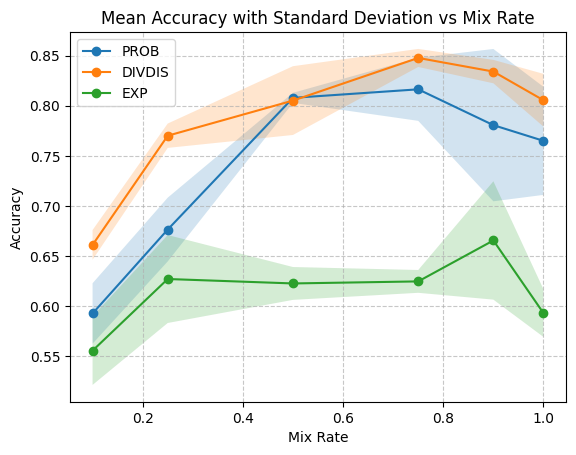

In [11]:
plot_acc_results(results)

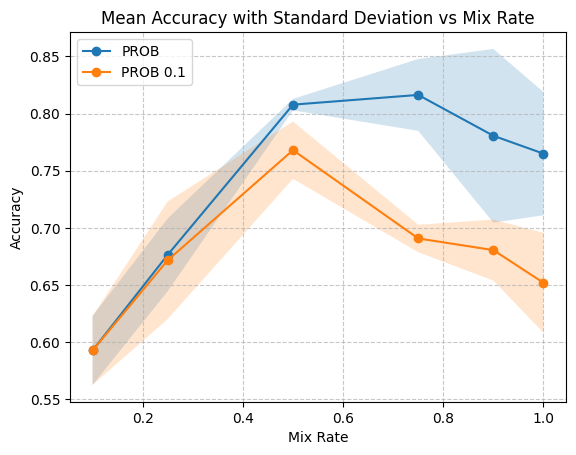

In [12]:
prob_results = {
    LossType.PROB: results[LossType.PROB], 
    **{LossType.PROB.name + f" {lb}": results_fixed_lower_bound[lb][LossType.PROB] 
       for lb in mix_rate_lower_bounds}
}
plot_acc_results(prob_results)

## Aggregate Validation Loss Selection

In [13]:
model_selection = "min_val_loss"
results_val_loss = get_acc_results(experiments, model_selection=model_selection)

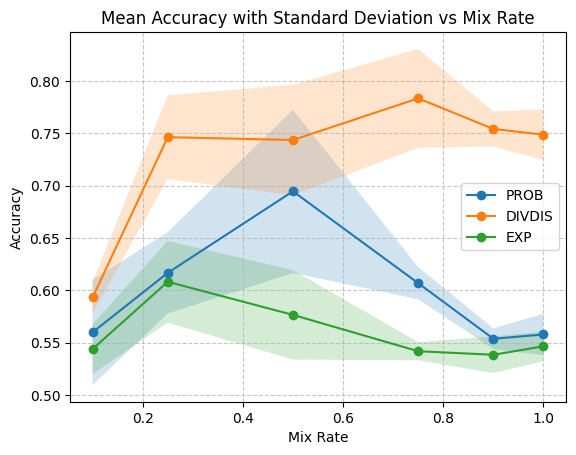

In [14]:
plot_acc_results(results_val_loss)

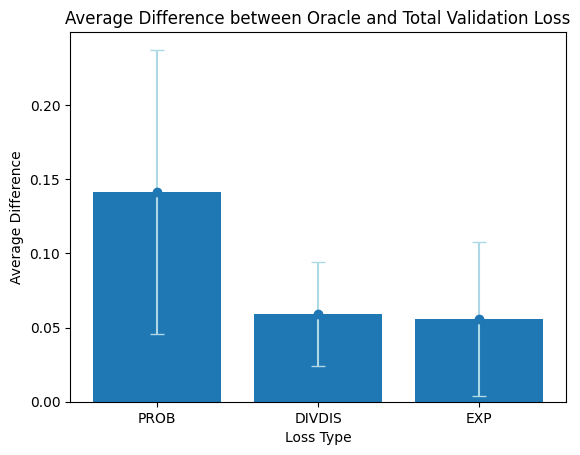

In [16]:
# compute average difference between oracle and validation loss across mix rates and runs 
def plot_model_selection_diffs(results, results_model_selection, model_selection_name: str):
    model_selection_diffs = defaultdict(list)
    # iterate over each loss type and results 
    for loss_type in losses: 
        for mix_rate in mix_rates:
            oracle_acc = results[loss_type][mix_rate]
            model_select_acc = results_model_selection[loss_type][mix_rate]
            diffs = (np.array(oracle_acc) - np.array(model_select_acc)).tolist()
            model_selection_diffs[loss_type].extend(diffs)

    # plot diff means and standad deviations as bar chart 
    model_selecttion_diffs_means = {loss_type.name: np.mean(diffs) for loss_type, diffs in model_selection_diffs.items()}
    model_selecttion_diffs_stds = {loss_type.name: np.std(diffs) for loss_type, diffs in model_selection_diffs.items()}
    plt.bar(model_selecttion_diffs_means.keys(), model_selecttion_diffs_means.values())
    plt.errorbar(model_selecttion_diffs_means.keys(), model_selecttion_diffs_means.values(), 
                 yerr=model_selecttion_diffs_stds.values(), fmt='o', capsize=5, ecolor='lightblue')
    plt.xlabel('Loss Type')
    plt.ylabel('Average Difference')
    plt.title(f'Average Difference between Oracle and {model_selection_name}')
    plt.show()

plot_model_selection_diffs(results, results_val_loss, "Total Validation Loss")


## Repulsion Loss Selection 

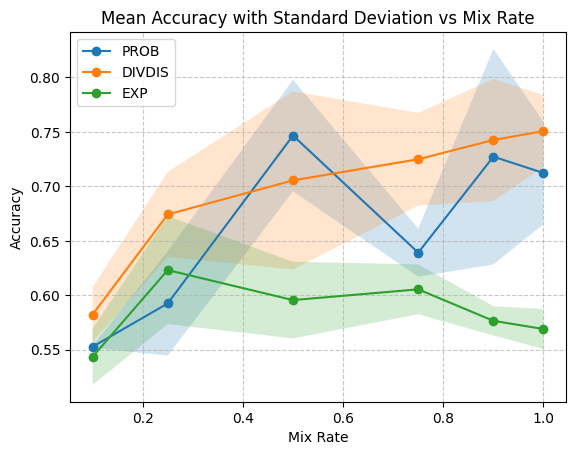

In [17]:
model_selection = "min_repulsion_loss"
results_repulsion_loss = get_acc_results(experiments, model_selection=model_selection)
plot_acc_results(results_repulsion_loss)

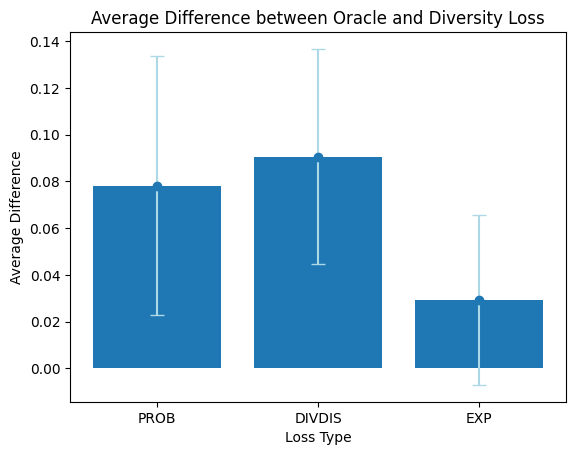

In [18]:
plot_model_selection_diffs(results, results_repulsion_loss, "Diversity Loss")

# Accuracy over Epochs

In [91]:
# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results_over_epochs(
    experiments: list[Experiment], 
    lower_bound: Optional[float]=None
):
    results = defaultdict(lambda: defaultdict(list))
    for exp in experiments:
        if lower_bound is not None and exp.mix_rate_lower_bound != lower_bound:
            continue
        elif lower_bound is None:
            if exp.mix_rate != exp.mix_rate_lower_bound:
                continue
        exp_metrics = get_exp_metrics(exp)
        # take max over epoch_acc_0, epoch_acc_1
        max_acc = np.maximum(np.array(exp_metrics['epoch_acc_0']), np.array(exp_metrics['epoch_acc_1']))
        results[exp.loss_type][exp.mix_rate].append(max_acc)
    results = {k: dict(v) for k, v in results.items()}
    return results

results_acc_over_epochs = get_acc_results_over_epochs(experiments)

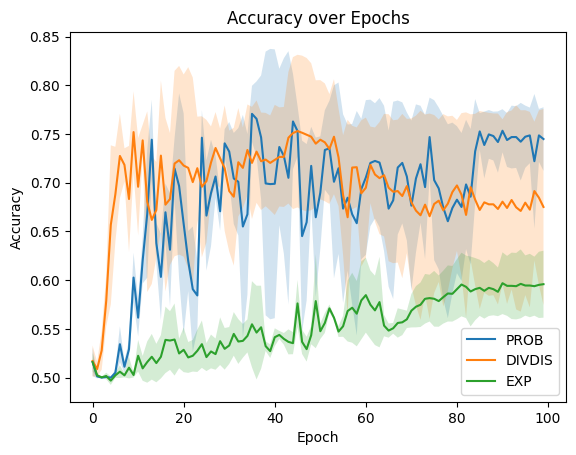

In [98]:
mix_rate = 0.5 

for loss_type, loss_type_acc_over_epochs in results_acc_over_epochs.items():
    # compute mean and std over seeds
    mean_acc_over_epochs = np.mean(loss_type_acc_over_epochs[mix_rate], axis=0)
    std_acc_over_epochs = np.std(loss_type_acc_over_epochs[mix_rate], axis=0)
    plt.plot(mean_acc_over_epochs, label=f"{loss_type.name}")
    plt.fill_between(range(len(mean_acc_over_epochs)), 
                     mean_acc_over_epochs - std_acc_over_epochs,
                     mean_acc_over_epochs + std_acc_over_epochs,
                     alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()